# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral Cloning

---
## Step 0: Load The Data

In [0]:
#importing some useful packages
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import os

import cv2
%matplotlib inline
IMG_HEIGHT = 160
IMG_WIDTH = 320//2

In [0]:
# !mkdir car
# proj_folder = Path("/content/car")
# os.chdir(proj_folder)
# !git clone https://github.com/udacity/CarND-Behavioral-Cloning-P3
proj_folder = Path("/content/car/CarND-Behavioral-Cloning-P3/") 
os.chdir(proj_folder)
!ls

data		  history_3.pickle  model2.h5	 model5.h5
data.zip	  history_4.pickle  model2.json  model5.json
drive.py	  history_5.pickle  model3.h5	 README.md
examples	  LICENSE	    model3.json  set_git.sh
history_1.pickle  model1.h5	    model4.h5	 video.py
history_2.pickle  model1.json	    model4.json  writeup_template.md


In [0]:
#data_dir = "data"
#!mkdir {data_dir}
#os.chdir(data_dir)
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
!unzip -o data.zip
!rm -rf {os.path.join(proj_folder, '__MACOSX')}
!ls

In [0]:
data_dir = "data"
os.chdir(data_dir)
!ls

driving_log.csv  IMG


In [0]:
log_file = 'driving_log.csv'
img_ds = pd.read_csv(log_file)# names=['center','left','right','steering']) #,throttle,brake,speed])
img_ds.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [0]:
print(img_ds.steering.max())
print(img_ds.steering.min())
print(img_ds[img_ds.steering!=0.0].steering.abs().min())

1.0
-0.9426954
0.002791043


In [0]:
img_ds['l'] = 0
img_ds['r'] = 0
img_ds['o'] = 0
img_ds.loc[img_ds.steering<0, 'l'] = 1
img_ds.loc[img_ds.steering>0, 'r'] = 1
img_ds.loc[img_ds.steering==0.0, 'o'] = 1
img_ds.head()

,center,left,right,steering,throttle,brake,speed,l,r,o
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290,0,0,1
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630,0,0,1
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011,0,0,1
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419,0,0,1
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236,0,0,1


In [0]:
display(img_ds[img_ds.steering>0].head(3))
display(img_ds[img_ds.steering<0].head(3))

,center,left,right,steering,throttle,brake,speed,l,r,o
51,IMG/center_2016_12_01_13_32_43_457.jpg,IMG/left_2016_12_01_13_32_43_457.jpg,IMG/right_2016_12_01_13_32_43_457.jpg,0.061760,0.985533,0.0,2.124567,0,1,0
52,IMG/center_2016_12_01_13_32_43_558.jpg,IMG/left_2016_12_01_13_32_43_558.jpg,IMG/right_2016_12_01_13_32_43_558.jpg,0.052191,0.985533,0.0,3.286475,0,1,0
53,IMG/center_2016_12_01_13_32_43_659.jpg,IMG/left_2016_12_01_13_32_43_659.jpg,IMG/right_2016_12_01_13_32_43_659.jpg,0.052191,0.985533,0.0,4.440864,0,1,0


,center,left,right,steering,throttle,brake,speed,l,r,o
78,IMG/center_2016_12_01_13_32_46_185.jpg,IMG/left_2016_12_01_13_32_46_185.jpg,IMG/right_2016_12_01_13_32_46_185.jpg,-0.078746,0.985533,0.0,29.91009,1,0,0
79,IMG/center_2016_12_01_13_32_46_285.jpg,IMG/left_2016_12_01_13_32_46_285.jpg,IMG/right_2016_12_01_13_32_46_285.jpg,-0.078746,0.985533,0.0,30.18595,1,0,0
80,IMG/center_2016_12_01_13_32_46_385.jpg,IMG/left_2016_12_01_13_32_46_385.jpg,IMG/right_2016_12_01_13_32_46_385.jpg,-0.078746,0.985533,0.0,30.18617,1,0,0


In [0]:
#img_ds.steering = img_ds.steering.abs()
filter = img_ds['steering'] != 0.0
#img_ds = img_ds[filter]
display(img_ds[img_ds.r==1].head(3))
display(img_ds[img_ds.l==1].head(3))

,center,left,right,steering,throttle,brake,speed,l,r,o
51,IMG/center_2016_12_01_13_32_43_457.jpg,IMG/left_2016_12_01_13_32_43_457.jpg,IMG/right_2016_12_01_13_32_43_457.jpg,0.061760,0.985533,0.0,2.124567,0,1,0
52,IMG/center_2016_12_01_13_32_43_558.jpg,IMG/left_2016_12_01_13_32_43_558.jpg,IMG/right_2016_12_01_13_32_43_558.jpg,0.052191,0.985533,0.0,3.286475,0,1,0
53,IMG/center_2016_12_01_13_32_43_659.jpg,IMG/left_2016_12_01_13_32_43_659.jpg,IMG/right_2016_12_01_13_32_43_659.jpg,0.052191,0.985533,0.0,4.440864,0,1,0


,center,left,right,steering,throttle,brake,speed,l,r,o
78,IMG/center_2016_12_01_13_32_46_185.jpg,IMG/left_2016_12_01_13_32_46_185.jpg,IMG/right_2016_12_01_13_32_46_185.jpg,-0.078746,0.985533,0.0,29.91009,1,0,0
79,IMG/center_2016_12_01_13_32_46_285.jpg,IMG/left_2016_12_01_13_32_46_285.jpg,IMG/right_2016_12_01_13_32_46_285.jpg,-0.078746,0.985533,0.0,30.18595,1,0,0
80,IMG/center_2016_12_01_13_32_46_385.jpg,IMG/left_2016_12_01_13_32_46_385.jpg,IMG/right_2016_12_01_13_32_46_385.jpg,-0.078746,0.985533,0.0,30.18617,1,0,0


In [0]:
display(img_ds.shape, img_ds[~filter].head())

(8036, 10)

,center,left,right,steering,throttle,brake,speed,l,r,o
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290,0,0,1
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630,0,0,1
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011,0,0,1
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419,0,0,1
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236,0,0,1


In [0]:
img_ds.loc[~filter, ('steering')] = 0.001
filter = img_ds['steering'] != 0.0
img_ds.shape, img_ds[filter].shape

((8036, 10), (3675, 10))

NOTE: cv2.imread will get images in BGR format, while drive.py uses RGB. In the video above one way you could keep the same image formatting is to do "image = ndimage.imread(current_path)" with "from scipy import ndimage" instead.

---
## Step 1: Model

Main Udacity workspace lybraries:
keras.__version__
'2.0.9'

tf.__version__
'1.3.0'

pd.__version__
'0.23.3'

np.__version__
'1.12.1'

mtlib.__version__
'2.1.0'

cv2.__version__
'3.2.0'

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, \
    GlobalAveragePooling2D, BatchNormalization, Activation, Cropping2D
from tensorflow.keras.models import load_model, model_from_json    
from tensorflow.keras.utils import to_categorical    
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
#!pip install tensorflow-addons
import tensorflow_addons as tfa

In [0]:
batch_size = 32
epochs = 50

### Data generator

In [0]:
# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
#     vertical_flip=False, rescale=None, preprocessing_function=None,
#     data_format=None, validation_split=0.0, dtype=None)

In [0]:
data_gen_args = dict(#samplewise_center=True,
                     #samplewise_std_normalization=True,
                     #rotation_range=50,
                     #zca_whitening=True, 
                     #zca_epsilon=1e-06,
                     #zoom_range=0.2,
                     rescale=1./255,
                     #width_shift_range=0.2,
                     #height_shift_range=0.2,
                     validation_split=0.2,
                     fill_mode='nearest' # constant or nearest
                     #, cval=0.0 # when 'constant'
                     )
image_datagen = ImageDataGenerator(**data_gen_args)
#valid_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
# Only required if featurewise_center or featurewise_std_normalization or zca_whitening are set to True.
#image_datagen.fit(X_train, augment=True, seed=seed) 
#valid_datagen.fit(X_valid, augment=True, seed=seed)

In [0]:
data_gen_args2 = dict(#samplewise_center=True,
                    samplewise_std_normalization=True,
                    rescale=1./255)
test_datagen = ImageDataGenerator(**data_gen_args2)
# Only required if featurewise_center or featurewise_std_normalization or zca_whitening are set to True.
#test_datagen.fit(X_test, augment=True, seed=seed)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
# ImageDataGenerator.flow_from_dataframe(
#     dataframe,
#     directory=None,
#     x_col="filename",
#     y_col="class",
#     weight_col=None,
#     target_size=(256, 256),
#     color_mode="rgb",
#     classes=None,
#     class_mode="categorical",
#     batch_size=32,
#     shuffle=True,
#     seed=None,
#     save_to_dir=None,
#     save_prefix="",
#     save_format="png",
#     subset=None,
#     interpolation="nearest",
#     validate_filenames=True,
#     **kwargs
# )
#train_generator=datagen.flow_from_dataframe(dataframe=df, x_col="id", y_col="label", 
#                                            class_mode="categorical", target_size=(32,32), batch_size=32)

#train_gen = image_datagen.flow_from_dataframe(img_ds, x_col="center", y_col='steering', class_mode="raw", batch_size=batch_size)
# y_col=['steering', 'o', 'l', 'r']
train_gen = image_datagen.flow_from_dataframe(img_ds, x_col="center", y_col='steering', class_mode="raw", # multi_output raw
                                              target_size=(IMG_HEIGHT,IMG_WIDTH), color_mode="rgb", batch_size=batch_size,
                                              subset='training')
valid_gen = image_datagen.flow_from_dataframe(img_ds, x_col="center", y_col='steering', class_mode="raw", 
                                              target_size=(IMG_HEIGHT,IMG_WIDTH), color_mode="rgb", batch_size=batch_size,
                                              subset='validation')
print(len(train_gen), len(valid_gen))

Found 6429 validated image filenames.
Found 1607 validated image filenames.
201 51


In [0]:
def MultiOutputGen(ImageDataGenerator):
    def flow_from_dataframe(
        dataframe,
        directory=None,
        x_col="filename",
        y_col="class",
        weight_col=None,
        target_size=(256, 256),
        color_mode="rgb",
        classes=None,
        class_mode="categorical",
        batch_size=32,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        save_prefix="",
        save_format="png",
        subset=None,
        interpolation="nearest",
        validate_filenames=True,
        **kwargs
    ):
        gen = ImageDataGenerator.flow_from_dataframe(self,
            dataframe=dataframe,
            directory=directory,
            x_col=x_col,
            y_col=y_col,
            weight_col=weight_col,
            target_size=target_size,
            color_mode=color_mode,
            classes=classes,
            class_mode=class_mode,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            subset=subset,
            interpolation=interpolation,
            validate_filenames=validate_filenames,
            kwargs=kwargs
        )
        while True:
            X, Y = gen.next()
            yield X, np.array(Y[0]).reshape(batch_size,1), np.array(Y[1:]).reshape(batch_size,3)

In [0]:
class MultiOutputGen(object):
    def __init__(self, generator, img_dataframe, x_col, y_col, class_mode, batch_size, target_size, color_mode, subset):
        self.gen = generator.flow_from_dataframe(img_dataframe, x_col=x_col, y_col=y_col, class_mode=class_mode, 
                            batch_size=batch_size, target_size=target_size, color_mode=color_mode, subset=subset)
        self.length = len(self.gen)
        self.batch_size = batch_size
        #print(self.gen, self.length)

    def __len__(self): 
        return self.length

    def __iter__(self):
        self._gen = self._generator()
        return self._gen

    def _flip_batch(self, X, Y):
        if np.random.uniform()>0.5:
            image_flipped = np.fliplr(image) # X_in[i,:,:,:] = cv2.flip(X_in[i,:,:,:],1)
            measurement_flipped = -measurement # Y_in[i] = -p[i]
        return X, Y

    def _flip_images(self, X, Y1, Y2):
        for i in range(X.shape[0]):
            if np.random.uniform()>0.5:
                X[i,:,:,:] = cv2.flip(X[i,:,:,:],1)
                Y1[i] = -Y1[i]
                y_tmp = Y2[i,-1]
                Y2[i,-1] = Y2[i,-2]
                Y2[i,-2] = y_tmp
        return X, Y1, Y2

    def _generator(self):
        while True:
            X, Y = self.gen.next()
            Y1 = np.array(Y[0])[:,np.newaxis]
            Y2 = np.array(Y[1:]).T
            X, Y1, Y2 = self._flip_images(X, Y1, Y2)
            self.batch_size = X.shape[0]
            yield X, [Y1, Y2]
            #yield X, [np.array(Y[0]).reshape(self.batch_size,1), np.array(Y[1:]).reshape(self.batch_size,3)]

    def __next__(self):
        return next(self._generator())


In [0]:

#g = some_generator()
#h = GeneratorLen(g, 1)
#print len(h), list(h)
# Network output ['steering', ('o', 'l', 'r')]
train_gen_m = MultiOutputGen(image_datagen, img_ds, "center", ['steering', 'o', 'l', 'r'], "multi_output", # multi_output raw
                                    batch_size, (IMG_HEIGHT,IMG_WIDTH), "rgb",
                                              'training')
valid_gen_m = MultiOutputGen(image_datagen, img_ds, "center", ['steering', 'o', 'l', 'r'], "multi_output", # multi_output raw
                                    batch_size, (IMG_HEIGHT,IMG_WIDTH), "rgb",
                                              'validation')
print(len(train_gen_m), len(valid_gen_m))

Found 6429 validated image filenames.
Found 1607 validated image filenames.
201 51


In [0]:
def multiple_outputs(generator, img_dataframe, x_col, y_col, class_mode, batch_size, target_size, color_mode, subset):
    gen = generator.flow_from_dataframe(img_dataframe, x_col=x_col, y_col=y_col, class_mode=class_mode, 
                        batch_size=batch_size, target_size=target_size, color_mode=color_mode, subset=subset)
    print(gen, len(gen))
    while True:
        X, Y = gen.next()
        yield X, [np.array(Y[0]).reshape(batch_size,1), np.array(Y[1:]).reshape(batch_size,3)]

In [0]:
batch_size = 32        
train_gen_m2 = multiple_outputs(image_datagen, img_ds, "center", ['steering', 'o', 'l', 'r'], "multi_output", # multi_output raw
                                    batch_size, (IMG_HEIGHT,IMG_WIDTH), "rgb",
                                              'training')
valid_gen_m2 = multiple_outputs(image_datagen, img_ds, "center", ['steering', 'o', 'l', 'r'], "multi_output", # multi_output raw
                                    batch_size, (IMG_HEIGHT,IMG_WIDTH), "rgb",
                                              'validation')

In [0]:
for pict, y in train_gen:
    print(pict.shape, y.shape)
    break

(32, 160, 160, 3) (32,)


In [0]:
pict, [y1, y2] = next(train_gen)
print(y1.shape, y2.shape)

(32, 1) (32, 3)


In [0]:
for i in range(32):
    print(i, y1[i], y2[i])

0 [0.04262284] [0 0 1]
1 [-0.06925154] [0 1 0]
2 [-0.1861508] [0 1 0]
3 [0.] [1 0 0]
4 [0.] [1 0 0]
5 [0.] [1 0 0]
6 [0.] [1 0 0]
7 [0.2116669] [0 0 1]
8 [-0.505992] [0 1 0]
9 [0.0904655] [0 0 1]
10 [-0.03127411] [0 1 0]
11 [0.] [1 0 0]
12 [0.] [1 0 0]
13 [0.] [1 0 0]
14 [0.2781274] [0 0 1]
15 [0.2722676] [0 0 1]
16 [-0.2876218] [0 1 0]
17 [-0.] [1 0 0]
18 [0.06925154] [0 0 1]
19 [-0.] [1 0 0]
20 [0.06925154] [0 0 1]
21 [0.07132844] [0 0 1]
22 [-0.] [1 0 0]
23 [-0.04076847] [0 1 0]
24 [-0.] [1 0 0]
25 [-0.] [1 0 0]
26 [0.] [1 0 0]
27 [0.03127411] [0 0 1]
28 [-0.0617599] [0 1 0]
29 [0.9426954] [0 0 1]
30 [0.] [1 0 0]
31 [-0.] [1 0 0]


In [0]:
obj = next(train_gen)
len(obj)

2

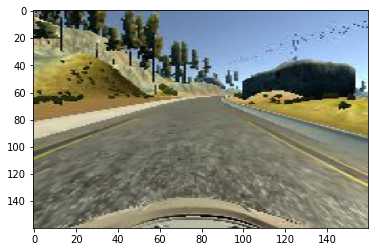

In [0]:
plt.imshow(pict[1], aspect='auto')

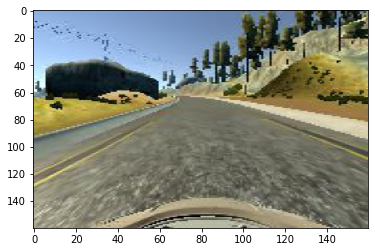

In [0]:
plt.imshow(cv2.flip(pict[1,:,:,:],1), aspect='auto')

### Telegram

In [0]:
import json
import requests

def to_telegram(mess, cmd=None):
    bot_id = "867533512:AAGgw33CTqg4QAXy4XyRbC....."
    chat_id="123456789"
    if cmd is None:
        address="https://api.telegram.org/bot" + bot_id + "/sendMessage"
        data = {'chat_id': chat_id, 'text': mess}
    else:
        address="https://api.telegram.org/bot" + bot_id + cmd
        data = {'chat_id': chat_id}
        print('cmd:{}'.format(cmd))
    try:
        r = requests.post(address, data=data)
        print("telegram API result:", r)
    except (HTTPSConnectionPool, TimeoutError) as err:
        if '200' in err:
            print("telegram API result: {}".format(err))
        else:
            print('to_telegram failed: {}'.format(err))
    else:
        print('to_telegram failed.')

class YourTelegramCallback(tf.keras.callbacks.Callback):

    def on_train_batch_end(self, batch, logs=None):
        pass
        #print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

    def on_test_batch_end(self, batch, logs=None):
        pass
        #print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))

    def on_epoch_end(self, epoch, logs=None):
        #print('The average loss for epoch {} is {:7.2f} and mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['mae']))
        #to_telegram('Epoch {}, val_loss {:7.3f}, val_dice_coef {:7.3f}.'.format(epoch, logs['val_loss'], logs['val_dice_coef']))
        to_telegram('Epoch {}, val_loss {:7.3f}, val_acc {:7.3f}.'.format(epoch, logs['val_loss'], logs['val_accuracy']))


### Utils

In [0]:
def plot_history(history, title, ix_number=-1, y_true=None, bins=50, accuracy=[]):    
    
  # plot train and validation loss
# history - dictionary
# loss, val_loss - keys for the plot
# accuracy=['accuracy', 'val_accuracy'] - keys for the accuracy plot
# ix_number - list index of the list values in history['pred'][ix_number] or the last one default
# pred - key and values list must match y_true length for the histogram
# bins - bins quantity for the hystogram

  fig = plt.figure(figsize=(14,5))
  ax = fig.add_subplot(1, 2, 1)
  ax.set_title(title)
  ax.plot(history['loss'], label='Model loss')
  ax.plot(history['val_loss'], label='Model val_loss')
  ax.set_ylabel('loss')
  ax.set_xlabel('epoch')
  if len(accuracy)==0:
    ax.legend(loc='upper right') #['train','validation'], loc='upper right')
  elif len(accuracy)==2:
    ax2 = ax.twinx()
    ax2.plot(history[accuracy[0]], label='Train')
    ax2.plot(history[accuracy[1]], label='Validation')
    ax2.set_ylabel('accuracy')
    ax2.legend(loc='right') 

  ax = fig.add_subplot(1, 2, 2)
  ax.set_title(title)
  if 'pred' in history.keys():
    if ix_number==-1:
        ix = len(history['pred'])-1
    else:
        ix = ix_number
    if y_true is None:
        ax.hist(history['pred'][ix], label='prediction', bins=bins)
    else:
        #ax.hist([history['pred'][ix], y_true], label=['prediction', 'y_true'], bins=bins)
        ax.hist(np.concatenate((history['pred'][ix], y_true), axis=1), 
                label=['prediction', 'y_true'], 
                color=['red', 'lime'], 
                bins=bins)
        ax.legend(prop={'size': 10})
        
    ax.set_xlabel('target')
    print('predictions ', len(history['pred']))
  fig.tight_layout()

  plt.show()

In [0]:
def save_model_n(data_folder, model, history_dict, mod_number):
      # serialize model to JSON
  model_json = model.to_json()
  file_to_save = data_folder / ("model" + str(mod_number) + ".json")
  with open(file_to_save, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5

  with open(file_to_save, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
  file_to_save = str(data_folder / ("model" + str(mod_number) + ".h5"))
  print('file_to_save:', file_to_save)
  model.save_weights(file_to_save)
  print("Saved model to disk")

  file_to_save = data_folder / ("history_" + str(mod_number) + ".pickle")
  with open(file_to_save, 'wb') as f:
      # Pickle the 'data' dictionary using the highest protocol available.
      pickle.dump(history_dict, f, pickle.HIGHEST_PROTOCOL)

In [0]:
def load_model_n(data_folder, mod_number):
  # load json and create model
  file_to_read = data_folder / ("model" + str(mod_number) + ".json")
  json_file = open(file_to_read, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)

  # load weights into new model
  file_to_read = data_folder / ("model" + str(mod_number) + ".h5")
  loaded_model.load_weights(str(file_to_read))
  print("Loaded model from disk")

  # evaluate loaded model on test data
  loaded_model.compile(loss='mse', optimizer='adam') #, metrics=['accuracy'])

  file_to_read = data_folder / ("history_" + str(mod_number) + ".pickle")
  with open(file_to_read, 'rb') as f:
      # The protocol version used is detected automatically, so we do not
      # have to specify it.
      history_ = pickle.load(f)
      
  return loaded_model, history_      

### Model Architecture

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) #val_accuracy

In [0]:
# models can be build with Keras or Tensorflow frameworks
# use keras and tfkeras modules respectively
# efficientnet.keras / efficientnet.tfkeras
!pip install -U efficientnet
import efficientnet.tfkeras as efn 

In [0]:
efficient_net = efn.EfficientNetB7(
    weights='noisy-student', # weights='noisy-student' or 'imagenet'
    input_shape=(32,32,3),
    include_top=False,
    pooling='max'
)

#Note: This API is new and only available in tf-nightly.
tf.keras.applications.EfficientNetB7(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None, # (n,n)
    pooling=[None, avg, max], classes=1000, classifier_activation='softmax', **kwargs)

In [0]:
#model_r = create_conv_net(pool='no+pool', drop_rate=0.25, padding='valid', batch_norm=True, dense_layers=[1096,512])
#model_r = create_resnet_model2out(dense_layers=[1096,512, 128, 32], top_crop=32)
model_e = create_effnet_model(drop_rate=0.2, dense_layers=[512, 128, 32], top_crop=31, pooling='avg')
model_e.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
croping_1 (Cropping2D)          (None, 129, 160, 3)  0           input_0[0][0]                    
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 65, 80, 64)   1728        croping_1[0][0]                  
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 65, 80, 64)   256         stem_conv[0][0]                  
______________________________________________________________________________________________

In [0]:
#model_r = create_conv_net(pool='no+pool', drop_rate=0.25, padding='valid', batch_norm=True, dense_layers=[1096,512])
#model_r = create_resnet_model2out(dense_layers=[1096,512, 128, 32], top_crop=32)
model_r = create_resnet_model(drop_rate=0.5, dense_layers=[1096,512, 128, 32], pooling=None, top_crop=64)
model_r.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 160, 320, 3) 0                                            
__________________________________________________________________________________________________
croping_1 (Cropping2D)          (None, 96, 320, 3)   0           input_0[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 326, 3)  0           croping_1[0][0]                  
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 160, 64)  9472        conv1_pad[0][0]                  
____________________________________________________________________________________________

In [0]:
# models can be build with Keras or Tensorflow frameworks
# use keras and tfkeras modules respectively
# efficientnet.keras / efficientnet.tfkeras
!pip install -U efficientnet
import efficientnet.tfkeras as efn 

# efficient_net = efn.EfficientNetB7(
#     weights='noisy-student', # weights='noisy-student' or 'imagenet'
#     input_shape=(32,32,3),
#     include_top=False,
#     pooling='max')

def create_effnet_model(drop_rate=0.1, rnet_out_name=None, dense_layers=[4096,512], top_crop=0, pooling='avg' #, # conv3_block3_out conv4_block6_out
                        #optimizer = tf.keras.optimizers.Adam(), loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
                        ):
    
    #resize images for ResNet! 224x224x3
    
    if top_crop > 0:
        inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='input_0')
        inputs = Cropping2D(cropping=((top_crop,0), (0,0)), name='croping_1')(inputs)
        base_model = efn.EfficientNetB7(weights= 'noisy-student', include_top=False, pooling=pooling, # None or avg or max
                                                input_shape= (IMG_HEIGHT - top_crop, IMG_WIDTH,3),
                                                input_tensor=inputs)
    else:
        base_model = efn.EfficientNetB7(weights= 'noisy-student', include_top=False, pooling=pooling, # None or avg or max
                                                input_shape= (IMG_HEIGHT, IMG_WIDTH,3))

    if rnet_out_name is None:
        x = base_model.output
    else:
        x = base_model.get_layer(rnet_out_name).output
    y = Flatten()(x)
    for i, neurons in enumerate(dense_layers):
        y = Dense(neurons, activation='relu', name='dense_a_'+str(neurons)+'_'+str(i))(y)
        y = Dropout(drop_rate, name='drop_a_'+str(neurons)+'_'+str(i))(y)

    outputs_angle = Dense(1, name='pred_angle')(y)
    model_f = tf.keras.Model(inputs=base_model.input, outputs=outputs_angle)
    return model_f

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.1.0)


In [0]:
#ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
#    pooling=None, classes=1000, **kwargs)
def create_resnet_model(drop_rate=0.1, rnet_out_name=None, dense_layers=[4096,512], top_crop=0, pooling='avg' #, # conv3_block3_out conv4_block6_out
                        #optimizer = tf.keras.optimizers.Adam(), loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
                        ):
    
    #resize images for ResNet! 224x224x3
    
    if top_crop > 0:
        inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='input_0')
        inputs = Cropping2D(cropping=((top_crop,0), (0,0)), name='croping_1')(inputs)
        base_model = tf.keras.applications.ResNet50(weights= 'imagenet', include_top=False, pooling=pooling, # None or avg or max
                                                input_shape= (IMG_HEIGHT - top_crop, IMG_WIDTH,3),
                                                input_tensor=inputs)
    else:
        base_model = tf.keras.applications.ResNet50(weights= 'imagenet', include_top=False, pooling=pooling, # None or avg or max
                                                input_shape= (IMG_HEIGHT, IMG_WIDTH,3))

    if rnet_out_name is None:
        x = base_model.output
    else:
        x = base_model.get_layer(rnet_out_name).output
    y = Flatten()(x)
    for i, neurons in enumerate(dense_layers):
        y = Dense(neurons, activation='relu', name='dense_a_'+str(neurons)+'_'+str(i))(y)
        y = Dropout(drop_rate, name='drop_a_'+str(neurons)+'_'+str(i))(y)

    outputs_angle = Dense(1, name='pred_angle')(y)
    model_f = tf.keras.Model(inputs=base_model.input, outputs=outputs_angle)
    return model_f

In [0]:
#ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
#    pooling=None, classes=1000, **kwargs)
def create_resnet_model2out(drop_rate=0.1, rnet_out_name=None, dense_layers=[4096,512], top_crop=0 #, # conv3_block3_out conv4_block6_out
                        #optimizer = tf.keras.optimizers.Adam(), loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
                        ):
    
    #resize images for ResNet! 224x224x3
    
    if top_crop > 0:
        inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='input_0')
        inputs = Cropping2D(cropping=((top_crop,0), (0,0)), name='croping_1')(inputs)
        base_model = tf.keras.applications.ResNet50(weights= 'imagenet', include_top=False, pooling='avg', # None or avg or max
                                                input_shape= (IMG_HEIGHT - top_crop, IMG_WIDTH,3),
                                                input_tensor=inputs)
    else:
        base_model = tf.keras.applications.ResNet50(weights= 'imagenet', include_top=False, pooling='avg', # None or avg or max
                                                input_shape= (IMG_HEIGHT, IMG_WIDTH,3))

    if rnet_out_name is None:
        x = base_model.output
    else:
        x = base_model.get_layer(rnet_out_name).output
    #x = GlobalAveragePooling2D()(x)
    z = Flatten()(x)
    y = z
    for i, neurons in enumerate(dense_layers):
        z = Dense(neurons, activation='relu', name='dense_d_'+str(neurons)+'_'+str(i))(z)
        z = Dropout(drop_rate, name='drop_d_'+str(neurons)+'_'+str(i))(z)

        y = Dense(neurons, activation='relu', name='dense_a_'+str(neurons)+'_'+str(i))(y)
        y = Dropout(drop_rate, name='drop_a_'+str(neurons)+'_'+str(i))(y)

    outputs_angle = Dense(1, name='pred_angle')(y)
    outputs_direction = Dense(3, activation='softmax', name='pred_dir')(z)
    model_f = tf.keras.Model(inputs=base_model.input, outputs=[outputs_angle, outputs_direction])
    #loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #optimizer = tf.keras.optimizers.Adam()
    #test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    #model_f.compile(optimizer=optimizer,
    #            loss=loss_object,
    #            metrics=['accuracy'])
    #model_r.summary()
    return model_f

In [0]:
#ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
#    pooling=None, classes=1000, **kwargs)
def create_resnet_model(drop_rate=0.1, rnet_out_name="conv3_block3_out",
                        optimizer = tf.keras.optimizers.Adam(), loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)):
    base_model = tf.keras.applications.ResNet50(weights= 'imagenet', include_top=False, input_shape= (IMG_HEIGHT, IMG_WIDTH,3))
    #x = base_model.output
    #x = base_model.get_layer("conv4_block6_out").output
    x = base_model.get_layer(rnet_out_name).output
    #x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu', name='dense_1')(x)
    x = Dropout(drop_rate, name='drop_1')(x)
    x = Dense(512, activation='relu', name='dense_2')(x)
    x = Dropout(drop_rate, name='drop_2')(x)
    #outputs = Dense(n_classes, name='predictions', activation= 'softmax')(x)
    outputs = Dense(n_classes, name='predictions')(x)
    model_r = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    #loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True) # used with one hot labels
    #loss_object = tf.keras.losses.SparseCategoricalCrossentropy( ) # used with integer labels
    
    #test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    model_r.compile(optimizer=optimizer,
                loss=loss_object,
                metrics=['accuracy'])
    return model_r

In [0]:
# radam = tfa.optimizers.RectifiedAdam()
# ranger = tfa.optimizers.Lookahead(radam, sync_period=10, slow_step_size=0.5)

# model_r = create_resnet_model(drop_rate=0.2, rnet_out_name="conv2_block3_out", optimizer = ranger)
# model_r.summary()

In [0]:
#tf.keras.utils.plot_model(model_r, show_shapes=True, dpi=64) #dilation_rate

In [0]:
def create_2kernel_cnn(drop_rate=0.2):
    padding='same'
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='input')
    x = Conv2D(16, 5, padding=padding, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3))(inputs)
    y = Conv2D(16, 3, padding=padding, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3))(inputs)
    x = MaxPooling2D()(x)
    y = MaxPooling2D()(y)
    x = Conv2D(32, 5, padding=padding, activation='relu')(x)
    y = Conv2D(32, 3, padding=padding, activation='relu')(y)
    x = MaxPooling2D()(x)
    y = MaxPooling2D()(y)
    x = Conv2D(64, 5, padding=padding, activation='relu')(x)
    y = Conv2D(64, 3, padding=padding, activation='relu')(y)
    x = MaxPooling2D()(x)
    y = MaxPooling2D()(y)
    x = Conv2D(128, 5, padding=padding, activation='relu')(x)
    y = Conv2D(128, 3, padding=padding, activation='relu')(y)
    x = tf.keras.layers.concatenate([x, y])
    x = Flatten()(x)
    x = Dense(2048, activation='relu', name='dense_1')(x)
    x = Dropout(drop_rate, name='drop_1')(x)
    x = Dense(512, activation='relu', name='dense_2')(x)
    x = Dropout(drop_rate, name='drop_2')(x)
    outputs = Dense(n_classes, name='predictions')(x)

    model_f = tf.keras.Model(inputs=inputs, outputs=outputs)
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    #test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    model_f.compile(optimizer=optimizer,
                loss=loss_object,
                metrics=['accuracy'])
    return model_f

In [0]:
#model_r = create_2kernel_cnn()
#model_r.summary()

In [0]:
#tf.keras.utils.plot_model(model_r, show_shapes=True, dpi=64)

In [0]:
def create_conv_net(pool='pool', padding='valid', drop_rate=0.2, activation='relu', dense_layers=[4096,512], batch_norm=False,
                  optimizer = 'adam', 
                  loss_object = []):
    #tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='input')
    x = Conv2D(32, 5, padding=padding, input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_1')(inputs)
    if pool=='pool':
        x = Activation(activation)(x)
        x = MaxPooling2D()(x)
    else:
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
    x = Conv2D(64, 5, padding=padding, name='conv_2')(x)
    x = Activation(activation)(x)
    if pool=='pool':
        x = MaxPooling2D()(x)
    x = Conv2D(128, 5, padding=padding, name='conv_3')(x)
    x = Activation(activation)(x)
    if pool=='pool':
        x = MaxPooling2D()(x)
    x = Conv2D(128, 5, padding=padding, name='conv_4')(x)
    x = Activation(activation)(x)
    if pool=='pool':
        x = MaxPooling2D()(x)
    x = MaxPooling2D()(x)
    y = Flatten()(x)
    z = y

    # x = Dense(dense_layers[1], activation='relu', name='dense_12')(x)
    # x = Dropout(drop_rate, name='drop_12')(x)

    for i, neurons in enumerate(dense_layers):
        z = Dense(neurons, activation='relu', name='dense_d_'+str(neurons)+str(i))(z)
        z = Dropout(drop_rate, name='drop_d_'+str(neurons)+str(i))(z)

        y = Dense(neurons, activation='relu', name='dense_a_'+str(neurons)+str(i))(y)
        y = Dropout(drop_rate, name='drop_a_'+str(neurons)+str(i))(y)

    # z = Dense(dense_layers[0], activation='relu', name='dense_212')(z)
    # z = Dropout(drop_rate, name='drop_212')(z)
    # z = Dense(dense_layers[1], activation='relu', name='dense_22')(z)
    # z = Dropout(drop_rate, name='drop_22')(z)
    outputs_angle = Dense(1, name='pred_angle')(x)
    outputs_direction = Dense(3, activation='softmax', name='pred_dir')(z)

    model_f = tf.keras.Model(inputs=inputs, outputs=[outputs_angle, outputs_direction])
    #loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #optimizer = tf.keras.optimizers.Adam()
    #test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    #model_f.compile(optimizer=optimizer,
    #            loss=loss_object,
    #            metrics=['accuracy'])
    #model_r.summary()
    return model_f

In [0]:
#model_r = create_conv_net(pool='no+pool', drop_rate=0.25, padding='valid', batch_norm=True, dense_layers=[1096,512])
#model_r = create_resnet_model2out(dense_layers=[1096,512, 128, 32], top_crop=32)
model_r = create_resnet_model(dense_layers=[1096,512, 128, 32], top_crop=32)
model_r.summary()

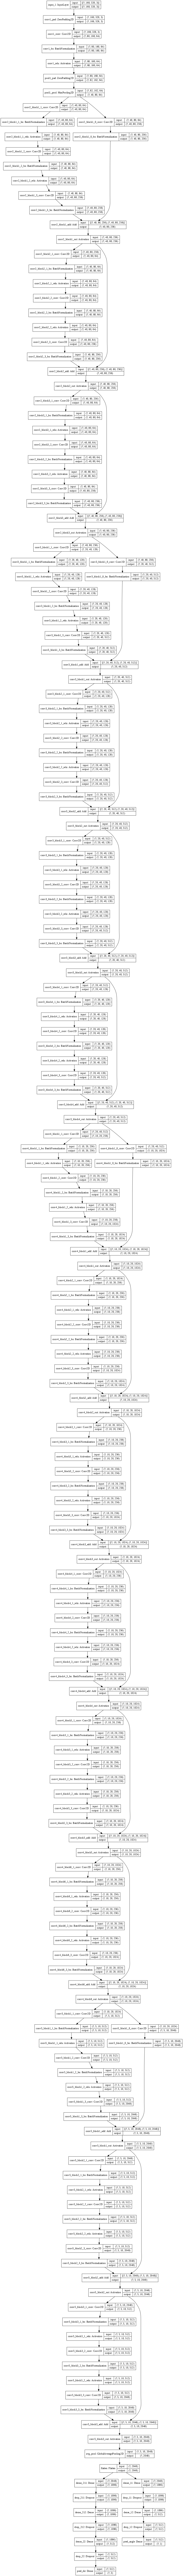

In [0]:
tf.keras.utils.plot_model(model_r, show_shapes=True, dpi=64)

In [0]:
radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

# losses = {
# 	"pred_angle": "mse",
# 	"pred_dir": "categorical_crossentropy",
# }
losses = "mse"
#metrics = ["mae", "accuracy"]
# metrics = {"pred_angle": "mae",
# 	"pred_dir": "accuracy"}
metrics = "mae"
#lossWeights = {"pred_angle": 0.2, "pred_dir": 0.8}
model_r.compile(loss=losses, optimizer=ranger, metrics=metrics) #, loss_weights=lossWeights
#model_r.summary()
#model_r.metrics_names

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [0]:
#for layer in model.layers:
#    print(layer.output_shape)
model_e.output_shape

(None, 1)

In [0]:
# losses = {
# 	"pred_angle": "mse",
# 	"pred_dir": "categorical_crossentropy",
# }
#metrics = ["mae", "accuracy"]
# metrics = {"pred_angle": "mae",
# 	"pred_dir": "accuracy"}
#lossWeights = {"pred_angle": 0.2, "pred_dir": 0.8}

#import tensorflow as tf
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

losses = "mse"
metrics = "mae"
model_e.compile(loss=losses, optimizer=ranger, metrics=metrics) #, options = run_opts) #, loss_weights=lossWeights
#model_r.summary()
history_dict = {}
history = model_e.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
save_model_n(proj_folder, model_e, history_dict, 6)

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
201/201 [==============================] - 161s 802ms/step - loss: 0.0172 - mae: 0.0714 - val_loss: 0.0146 - val_mae: 0.0652
Epoch 2/50
201/201 [==============================] - 158s 784ms/step - loss: 0.0171 - mae: 0.0714 - val_loss: 0.0147 - val_mae: 0.0669
Epoch 3/50
201/201 [==============================] - 156s 777ms/step - loss: 0.0171 - mae: 0.0718 - val_loss: 0.0147 - val_mae: 0.0670
Epoch 4/50
201/201 [==============================] - 157s 781ms/step - loss: 0.0171 - mae: 0.0715 - val_loss: 0.0148 - val_mae: 0.0671
Epoch 5/50
201/201 [==============================] - 157s 781ms/step - loss: 0.0171 - mae: 0.0717 - val_loss: 0.0147 - val_mae: 0.0661
Epoch 6/50
201/201 [==============================] - 156s 778ms/step - loss: 0.0171 - mae: 0.0720 - val_loss: 0.0146 - val_mae: 0.0653
Epoch 7/50
201/201 [==============================] - 156s 778ms/step - loss: 0.0171 - mae: 0.0714 - va

In [0]:
history_dict = {}
model_r.compile(loss='mse', optimizer='adam', metrics='mae')
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
save_model_n(proj_folder, model_r, history_dict, 5) # drop = 0.5, no_pool, crop=64, steering[=0]=0.001, Adam

Epoch 1/50
201/201 [==============================] - 31s 156ms/step - loss: 18.5388 - mae: 0.8937 - val_loss: 0.0178 - val_mae: 0.0895
Epoch 2/50
201/201 [==============================] - 30s 151ms/step - loss: 0.0186 - mae: 0.0850 - val_loss: 0.0161 - val_mae: 0.0781
Epoch 3/50
201/201 [==============================] - 30s 151ms/step - loss: 0.0176 - mae: 0.0789 - val_loss: 0.0154 - val_mae: 0.0729
Epoch 4/50
201/201 [==============================] - 31s 152ms/step - loss: 0.0171 - mae: 0.0759 - val_loss: 0.0152 - val_mae: 0.0715
Epoch 5/50
201/201 [==============================] - 31s 152ms/step - loss: 0.0165 - mae: 0.0732 - val_loss: 0.0151 - val_mae: 0.0705
Epoch 6/50
201/201 [==============================] - 31s 152ms/step - loss: 0.0165 - mae: 0.0717 - val_loss: 0.0147 - val_mae: 0.0666
Epoch 7/50
201/201 [==============================] - 30s 152ms/step - loss: 0.0162 - mae: 0.0712 - val_loss: 0.0144 - val_mae: 0.0658
Epoch 8/50
201/201 [==============================] - 

In [0]:
history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
save_model_n(proj_folder, model_r, history_dict, 4) # drop = 0.2, no_pool, crop=64, steering[=0]=0.001

Epoch 1/25
201/201 [==============================] - 53s 262ms/step - loss: 0.2804 - mae: 0.3459 - val_loss: 0.0226 - val_mae: 0.1268
Epoch 2/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0383 - mae: 0.1429 - val_loss: 0.1126 - val_mae: 0.3177
Epoch 3/25
201/201 [==============================] - 52s 256ms/step - loss: 0.0223 - mae: 0.1029 - val_loss: 0.0358 - val_mae: 0.1544
Epoch 4/25
201/201 [==============================] - 52s 258ms/step - loss: 0.0190 - mae: 0.0912 - val_loss: 0.0143 - val_mae: 0.0750
Epoch 5/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0158 - mae: 0.0818 - val_loss: 0.0121 - val_mae: 0.0648
Epoch 6/25
201/201 [==============================] - 52s 258ms/step - loss: 0.0143 - mae: 0.0773 - val_loss: 0.0112 - val_mae: 0.0641
Epoch 7/25
201/201 [==============================] - 52s 258ms/step - loss: 0.0140 - mae: 0.0739 - val_loss: 0.0100 - val_mae: 0.0607
Epoch 8/25
201/201 [==============================] - 5

In [0]:
history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
save_model_n(proj_folder, model_r, history_dict, 3) # drop = 0.2, no_pool, crop=64

Epoch 1/25
201/201 [==============================] - 54s 269ms/step - loss: 0.1792 - mae: 0.2753 - val_loss: 0.0272 - val_mae: 0.1419
Epoch 2/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0296 - mae: 0.1170 - val_loss: 0.0342 - val_mae: 0.1616
Epoch 3/25
201/201 [==============================] - 52s 259ms/step - loss: 0.0199 - mae: 0.0908 - val_loss: 0.0256 - val_mae: 0.1201
Epoch 4/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0172 - mae: 0.0835 - val_loss: 0.0153 - val_mae: 0.0731
Epoch 5/25
201/201 [==============================] - 52s 259ms/step - loss: 0.0147 - mae: 0.0774 - val_loss: 0.0116 - val_mae: 0.0638
Epoch 6/25
201/201 [==============================] - 52s 258ms/step - loss: 0.0128 - mae: 0.0730 - val_loss: 0.0105 - val_mae: 0.0621
Epoch 7/25
201/201 [==============================] - 52s 258ms/step - loss: 0.0127 - mae: 0.0714 - val_loss: 0.0097 - val_mae: 0.0614
Epoch 8/25
201/201 [==============================] - 5

In [0]:
history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
save_model_n(proj_folder, model_r, history_dict, 2) # drop = 0.2

Epoch 1/25
201/201 [==============================] - 53s 263ms/step - loss: 0.0517 - mae: 0.1549 - val_loss: 2.1978 - val_mae: 1.4772
Epoch 2/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0156 - mae: 0.0838 - val_loss: 2.4237 - val_mae: 1.5398
Epoch 3/25
201/201 [==============================] - 52s 258ms/step - loss: 0.0125 - mae: 0.0732 - val_loss: 0.0795 - val_mae: 0.2493
Epoch 4/25
201/201 [==============================] - 52s 258ms/step - loss: 0.0111 - mae: 0.0686 - val_loss: 0.0176 - val_mae: 0.0912
Epoch 5/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0095 - mae: 0.0632 - val_loss: 0.0111 - val_mae: 0.0656
Epoch 6/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0086 - mae: 0.0590 - val_loss: 0.0103 - val_mae: 0.0645
Epoch 7/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0072 - mae: 0.0546 - val_loss: 0.0098 - val_mae: 0.0665
Epoch 8/25
201/201 [==============================] - 5

In [0]:
history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
#save_model_n(proj_folder, model_r, history_dict, 1)

Epoch 1/25
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
201/201 [==============================] - 53s 266ms/step - loss: 0.0243 - mae: 0.1049 - val_loss: 1.2755 - val_mae: 1.1232
Epoch 2/25
201/201 [==============================] - 52s 257ms/step - loss: 0.0123 - mae: 0.0725 - val_loss: 2.4559 - val_mae: 1.5601
Epoch 3/25
201/201 [==============================] - 52s 258ms/step - loss: 0.0102 - mae: 0.0646 - val_loss: 0.1222 - val_mae: 0.3296
Epoch 4/25
201/201 [==============================] - 51s 255ms/step - loss: 0.0089 - mae: 0.0599 - val_loss: 0.0181 - val_mae: 0.0957
Epoch 5/25
201/201 [==============================] - 51s 255ms/step - loss: 0.0073 - mae: 0.0535 - val_loss: 0.0102 - val_mae: 0.0635
Epoch 6/25
201/201 [==============================] - 51s 255ms/step - loss: 0.0063 - mae: 0.0491 - val_loss: 0.0101 - val_mae: 0.0647
Epoch 7/25
201/201 [==============================] - 52s 256ms/step - loss: 0.0055 - mae: 0.0464 - val_loss:

In [0]:
history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
#save_model_n(proj_folder, model_r, history_dict, 1)

Epoch 1/25
201/201 [==============================] - 104s 515ms/step - loss: 0.7074 - pred_angle_loss: 0.0315 - pred_dir_loss: 0.8763 - pred_angle_mae: 0.1213 - pred_dir_accuracy: 0.6024 - val_loss: 3.3696 - val_pred_angle_loss: 0.1737 - val_pred_dir_loss: 4.1686 - val_pred_angle_mae: 0.4012 - val_pred_dir_accuracy: 0.5657
Epoch 2/25
201/201 [==============================] - 102s 509ms/step - loss: 0.5618 - pred_angle_loss: 0.0126 - pred_dir_loss: 0.6991 - pred_angle_mae: 0.0728 - pred_dir_accuracy: 0.6861 - val_loss: 1.4488 - val_pred_angle_loss: 0.0278 - val_pred_dir_loss: 1.8041 - val_pred_angle_mae: 0.1398 - val_pred_dir_accuracy: 0.5663
Epoch 3/25
201/201 [==============================] - 102s 509ms/step - loss: 0.5251 - pred_angle_loss: 0.0113 - pred_dir_loss: 0.6535 - pred_angle_mae: 0.0677 - pred_dir_accuracy: 0.7174 - val_loss: 0.9396 - val_pred_angle_loss: 0.0163 - val_pred_dir_loss: 1.1704 - val_pred_angle_mae: 0.0927 - val_pred_dir_accuracy: 0.5713
Epoch 4/25
201/201 [==

In [0]:
history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
#save_model_n(proj_folder, model_r, history_dict, 1)

Epoch 1/25
201/201 [==============================] - 104s 516ms/step - loss: 0.6536 - pred_angle_loss: 0.0503 - pred_dir_loss: 0.8044 - pred_angle_mae: 0.1665 - pred_dir_accuracy: 0.6203 - val_loss: 4.8606 - val_pred_angle_loss: 10.4120 - val_pred_dir_loss: 3.4727 - val_pred_angle_mae: 3.2249 - val_pred_dir_accuracy: 0.2134
Epoch 2/25
201/201 [==============================] - 101s 503ms/step - loss: 0.5252 - pred_angle_loss: 0.0130 - pred_dir_loss: 0.6532 - pred_angle_mae: 0.0817 - pred_dir_accuracy: 0.7076 - val_loss: 0.9464 - val_pred_angle_loss: 0.0137 - val_pred_dir_loss: 1.1795 - val_pred_angle_mae: 0.0969 - val_pred_dir_accuracy: 0.5893
Epoch 3/25
201/201 [==============================] - 101s 503ms/step - loss: 0.4852 - pred_angle_loss: 0.0105 - pred_dir_loss: 0.6038 - pred_angle_mae: 0.0698 - pred_dir_accuracy: 0.7367 - val_loss: 0.8503 - val_pred_angle_loss: 0.0161 - val_pred_dir_loss: 1.0588 - val_pred_angle_mae: 0.1072 - val_pred_dir_accuracy: 0.5600
Epoch 4/25
201/201 [=

In [0]:
history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
#save_model_n(proj_folder, model_r, history_dict, 1)

Epoch 1/25
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
201/201 [==============================] - 122s 606ms/step - loss: 0.6627 - pred_angle_loss: 0.0551 - pred_dir_loss: 0.8146 - pred_angle_mae: 0.1722 - pred_dir_accuracy: 0.6186 - val_loss: 4.7490 - val_pred_angle_loss: 3.1309 - val_pred_dir_loss: 5.1536 - val_pred_angle_mae: 1.7659 - val_pred_dir_accuracy: 0.2159
Epoch 2/25
201/201 [==============================] - 119s 593ms/step - loss: 0.5295 - pred_angle_loss: 0.0142 - pred_dir_loss: 0.6583 - pred_angle_mae: 0.0858 - pred_dir_accuracy: 0.7116 - val_loss: 0.8543 - val_pred_angle_loss: 0.1028 - val_pred_dir_loss: 1.0422 - val_pred_angle_mae: 0.3040 - val_pred_dir_accuracy: 0.5607
Epoch 3/25
201/201 [==============================] - 119s 593ms/step - loss: 0.4833 - pred_angle_loss: 0.0106 - pred_dir_loss: 0.6014 - pred_angle_mae: 0.0709 - pred_dir_accuracy: 0.7357 - val_loss: 1.0807 - val_pred_angle_loss: 0.0541 - val_pred_dir_loss: 1.3373 - 

In [0]:
history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
#save_model_n(proj_folder, model_r, history_dict, 1)

Epoch 1/25
201/201 [==============================] - 109s 540ms/step - loss: 0.9022 - pred_angle_loss: 0.0565 - pred_dir_loss: 0.8457 - pred_angle_mae: 0.1742 - pred_dir_accuracy: 0.6024 - val_loss: 1.5164 - val_pred_angle_loss: 0.0348 - val_pred_dir_loss: 1.4815 - val_pred_angle_mae: 0.1669 - val_pred_dir_accuracy: 0.5657
Epoch 2/25
201/201 [==============================] - 107s 530ms/step - loss: 0.7501 - pred_angle_loss: 0.0143 - pred_dir_loss: 0.7358 - pred_angle_mae: 0.0863 - pred_dir_accuracy: 0.6570 - val_loss: 4.5368 - val_pred_angle_loss: 0.0475 - val_pred_dir_loss: 4.4892 - val_pred_angle_mae: 0.1816 - val_pred_dir_accuracy: 0.5688
Epoch 3/25
201/201 [==============================] - 107s 531ms/step - loss: 0.7153 - pred_angle_loss: 0.0111 - pred_dir_loss: 0.7042 - pred_angle_mae: 0.0732 - pred_dir_accuracy: 0.6850 - val_loss: 1.0785 - val_pred_angle_loss: 0.0236 - val_pred_dir_loss: 1.0549 - val_pred_angle_mae: 0.1376 - val_pred_dir_accuracy: 0.5675
Epoch 4/25
201/201 [==

In [0]:
# H = model.fit(trainX,
# 	{"category_output": trainCategoryY, "color_output": trainColorY},
# 	validation_data=(testX,
# 		{"category_output": testCategoryY, "color_output": testColorY}),
#	"pred_angle": "mse",
#	"pred_dir": "categorical_crossentropy",

# 	epochs=EPOCHS,
# 	verbose=1)

history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
#save_model_n(proj_folder, model_r, history_dict, 1)

Epoch 1/5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
201/201 [==============================] - 64s 320ms/step - loss: 0.8237 - pred_angle_loss: 0.0524 - pred_dir_loss: 0.7713 - pred_angle_mae: 0.1672 - pred_dir_accuracy: 0.6474 - val_loss: 2.2222 - val_pred_angle_loss: 0.9569 - val_pred_dir_loss: 1.2653 - val_pred_angle_mae: 0.9729 - val_pred_dir_accuracy: 0.5657
Epoch 2/5
201/201 [==============================] - 62s 311ms/step - loss: 0.5817 - pred_angle_loss: 0.0129 - pred_dir_loss: 0.5688 - pred_angle_mae: 0.0814 - pred_dir_accuracy: 0.7519 - val_loss: 1.5911 - val_pred_angle_loss: 0.0251 - val_pred_dir_loss: 1.5660 - val_pred_angle_mae: 0.1412 - val_pred_dir_accuracy: 0.5669
Epoch 3/5
201/201 [==============================] - 62s 308ms/step - loss: 0.5061 - pred_angle_loss: 0.0099 - pred_dir_loss: 0.4962 - pred_angle_mae: 0.0674 - pred_dir_accuracy: 0.7874 - val_loss: 1.2931 - val_pred_angle_loss: 0.0137 - val_pred_dir_loss: 1.2795 - val_pr

In [0]:
# H = model.fit(trainX,
# 	{"category_output": trainCategoryY, "color_output": trainColorY},
# 	validation_data=(testX,
# 		{"category_output": testCategoryY, "color_output": testColorY}),
#	"pred_angle": "mse",
#	"pred_dir": "categorical_crossentropy",

# 	epochs=EPOCHS,
# 	verbose=1)

history_dict = {}
history = model_r.fit(train_gen,
        steps_per_epoch=len(train_gen),
        epochs=epochs, 
        validation_data=valid_gen,
        validation_steps = len(valid_gen),
        #validation_batch_size = 1,
        callbacks=[callback]) #YourTelegramCallback()

history_dict = history.history.copy()
#save_model_n(proj_folder, model_r, history_dict, 1)

Epoch 1/5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
201/201 [==============================] - 37s 185ms/step - loss: 0.8292 - pred_angle_loss: 0.0136 - pred_dir_loss: 0.8156 - pred_angle_accuracy: 0.5368 - pred_dir_accuracy: 0.6230 - val_loss: 0.7125 - val_pred_angle_loss: 0.0089 - val_pred_dir_loss: 0.7035 - val_pred_angle_accuracy: 0.5657 - val_pred_dir_accuracy: 0.6571
Epoch 2/5
201/201 [==============================] - 36s 178ms/step - loss: 0.6519 - pred_angle_loss: 0.0096 - pred_dir_loss: 0.6422 - pred_angle_accuracy: 0.5373 - pred_dir_accuracy: 0.7172 - val_loss: 0.7493 - val_pred_angle_loss: 0.0086 - val_pred_dir_loss: 0.7408 - val_pred_angle_accuracy: 0.5694 - val_pred_dir_accuracy: 0.6465
Epoch 3/5
201/201 [==============================] - 36s 177ms/step - loss: 0.6043 - pred_angle_loss: 0.0091 - pred_dir_loss: 0.5952 - pred_angle_accuracy: 0.5376 - pred_dir_accuracy: 0.7410 - val_loss: 0.8799 - val_pred_angle_loss: 0.0093 - val_pred_

In [0]:
test_loss, test_acc = model_r.evaluate(test_datagen.flow(X_test, y_test), verbose=2) 
print('\nTest accuracy:', test_acc)
to_telegram(f'test_datagen loss:{test_loss:<8.3f}, acc:{test_acc:<8.3f}')

395/395 - 2s - loss: 0.1997 - accuracy: 0.9552

Test accuracy: 0.9551860690116882
telegram API result: <Response [401]>
to_telegram failed.


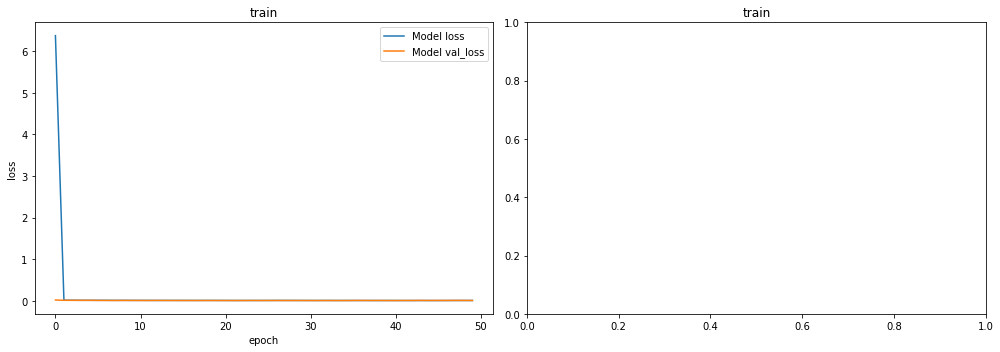

In [0]:
plot_history(history_dict,'train ResNet50')